In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pickle



## Read Data

In [2]:
bank_transactions = pd.read_csv('bank_transactions.csv',header = 0)

In [3]:
bank_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [4]:
bank_transactions.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


## Converting to date format

In [5]:
bank_transactions['CustomerDOB'] = pd.to_datetime(bank_transactions['CustomerDOB'], dayfirst = True, errors ='coerce')
bank_transactions['TransactionDate'] = pd.to_datetime(bank_transactions['TransactionDate'], dayfirst = True, errors ='coerce')

/var/folders/yz/08cygn91331522h9rw_0x6zr0000gn/T/ipykernel_90393/3836669962.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bank_transactions['CustomerDOB'] = pd.to_datetime(bank_transactions['CustomerDOB'], dayfirst = True, errors ='coerce')
/var/folders/yz/08cygn91331522h9rw_0x6zr0000gn/T/ipykernel_90393/3836669962.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bank_transactions['TransactionDate'] = pd.to_datetime(bank_transactions['TransactionDate'], dayfirst = True, errors ='coerce')


## Correcting date values

In [6]:
bank_transactions.loc[
    bank_transactions['CustomerDOB'].dt.year > bank_transactions['TransactionDate'].dt.year, 
    'CustomerDOB'
] = bank_transactions['CustomerDOB'] - pd.DateOffset(years=100)


In [7]:
bank_transactions.duplicated().sum()

0

In [8]:
bank_transactions.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [9]:
bank_transactions1 = bank_transactions

## Dropping irrelevant columns

In [10]:
bank_transactions1.drop(columns=['CustomerDOB','CustGender','CustLocation','TransactionTime'],axis = 1, inplace = True)

In [11]:
bank_transactions1.isnull().sum()

TransactionID                 0
CustomerID                    0
CustAccountBalance         2369
TransactionDate               0
TransactionAmount (INR)       0
dtype: int64

## Dropping Null Values

In [12]:
bank_clean = bank_transactions1.dropna()

In [13]:
bank_clean = bank_clean[(bank_clean['CustAccountBalance'] - bank_clean['TransactionAmount (INR)'])>=0]

In [14]:
bank_clean.head()
bank_clean.to_csv('cleaned_bank_transactions.csv')

## Frequency Calculation per Customer

In [15]:
rfm_trans_f = bank_clean.groupby('CustomerID')['TransactionID'].count().reset_index()
rfm_trans_f.head()

,CustomerID,TransactionID
0,C1010011,2
1,C1010012,1
2,C1010014,2
3,C1010018,1
4,C1010024,1


## Monetary Calculation per Customer

In [16]:
rfm_trans_m = bank_clean.groupby('CustomerID')['TransactionAmount (INR)'].sum().reset_index()
rfm_trans_m.head()

,CustomerID,TransactionAmount (INR)
0,C1010011,5106.0
1,C1010012,1499.0
2,C1010014,1455.0
3,C1010018,30.0
4,C1010024,5000.0


## Merging Frequency and Monetary

In [17]:
rfm_trans = pd.merge(rfm_trans_f, rfm_trans_m, on = 'CustomerID', how = 'inner')

## Recency Calculation per Customer

In [18]:
max_date = max(bank_clean['TransactionDate'])
bank_clean['Recency'] = (max_date - bank_clean['TransactionDate']).dt.days
rfm_trans_r = bank_clean.groupby('CustomerID')['Recency'].min().reset_index()

In [19]:
rfm_trans_r.head()

,CustomerID,Recency
0,C1010011,25
1,C1010012,68
2,C1010014,75
3,C1010018,36
4,C1010024,64


## Merging Recency with existing rfm dataframe

In [20]:
rfm_trans = pd.merge(rfm_trans, rfm_trans_r, on = 'CustomerID', how = 'inner')


In [21]:
rfm_trans.head()

,CustomerID,TransactionID,TransactionAmount (INR),Recency
0,C1010011,2,5106.0,25
1,C1010012,1,1499.0,68
2,C1010014,2,1455.0,75
3,C1010018,1,30.0,36
4,C1010024,1,5000.0,64


In [22]:
rfm_trans.columns = ['CustomerID','Frequency','Monetary','Recency']
rfm_trans.head()

,CustomerID,Frequency,Monetary,Recency
0,C1010011,2,5106.0,25
1,C1010012,1,1499.0,68
2,C1010014,2,1455.0,75
3,C1010018,1,30.0,36
4,C1010024,1,5000.0,64


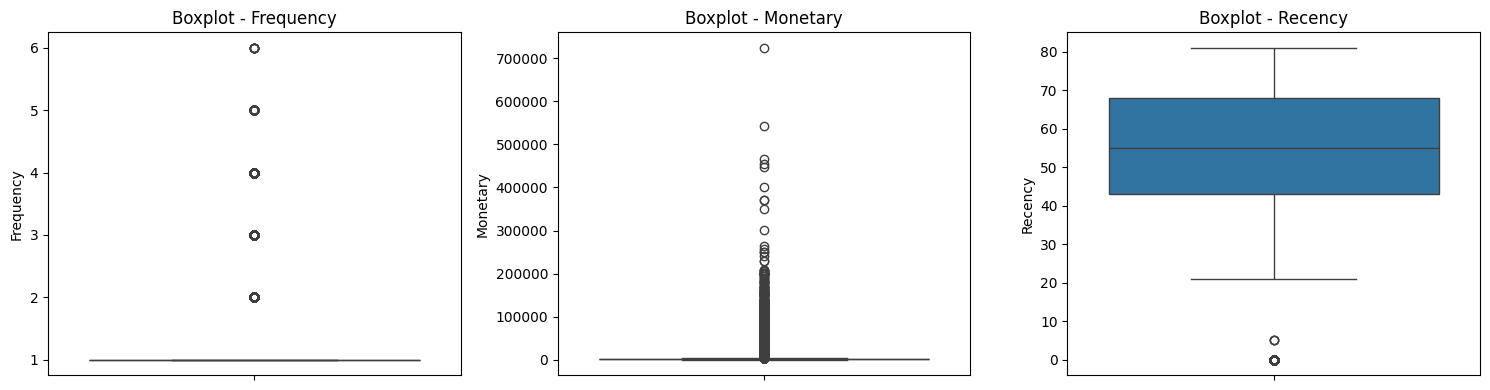

In [23]:
numeric_cols = rfm_trans.select_dtypes(include = np.number).columns.to_list()
plt.figure(figsize = (15,4))
for i, col in enumerate(numeric_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=rfm_trans[col])
    plt.title(f'Boxplot - {col}')
plt.tight_layout()

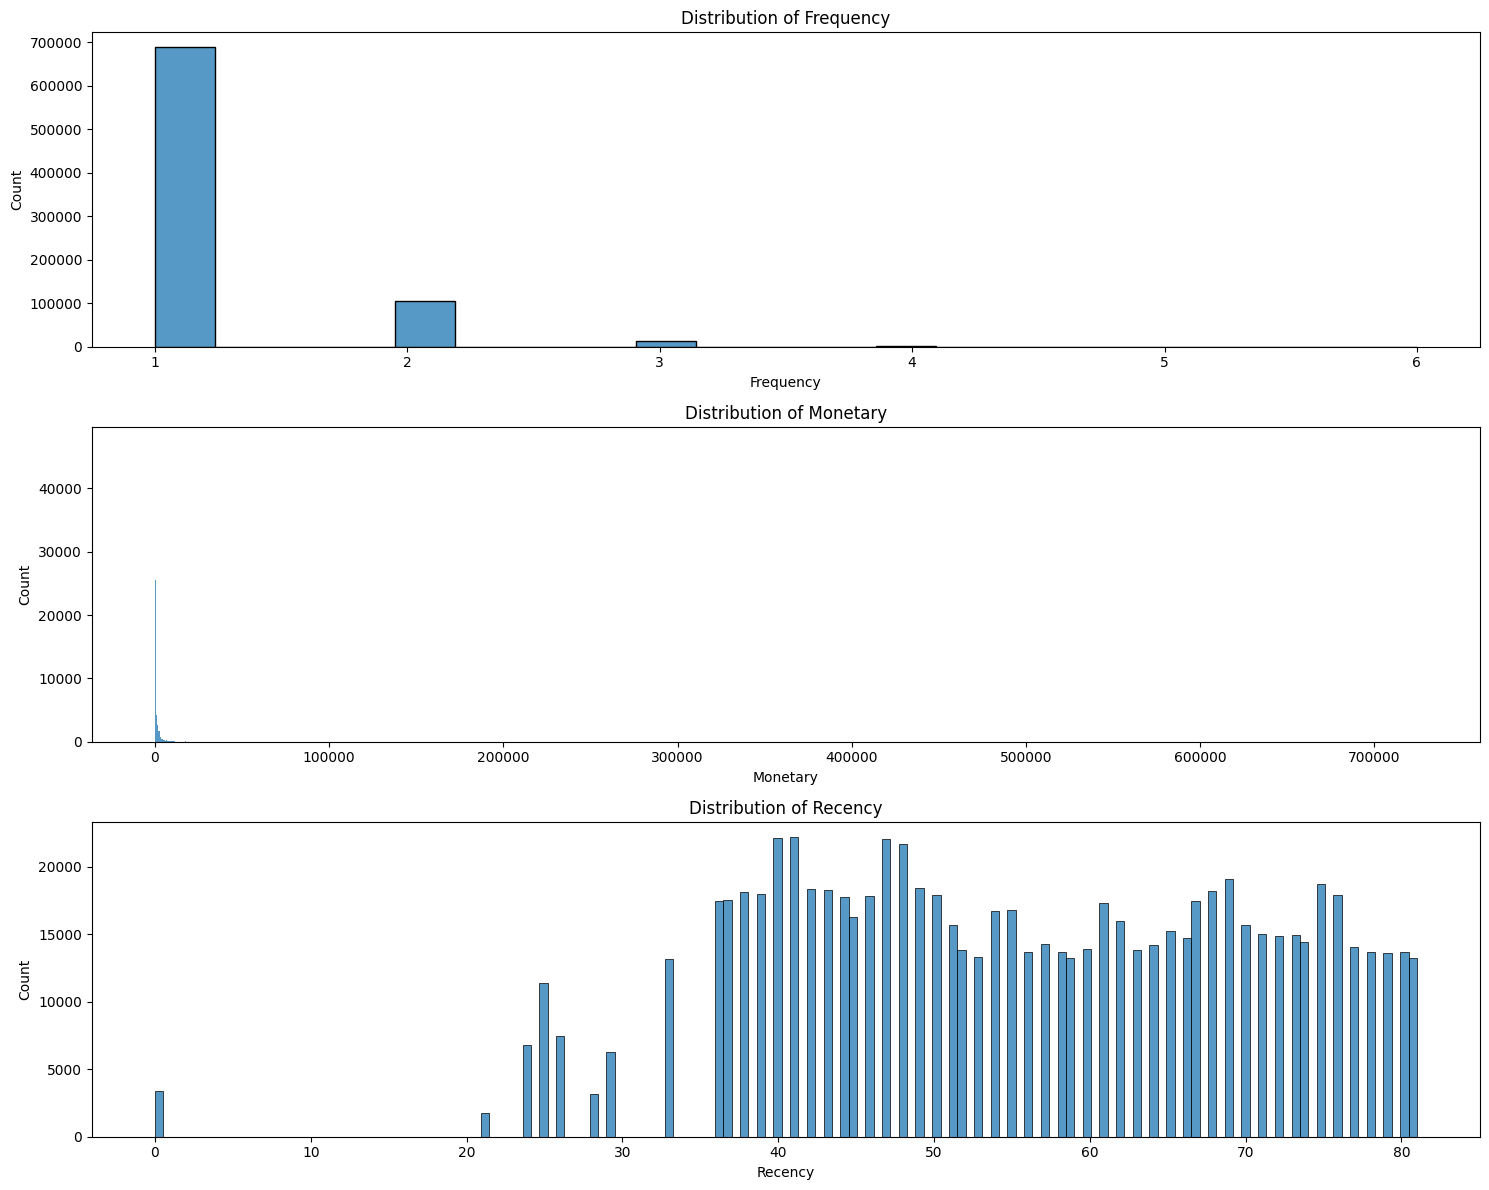

In [24]:
plt.figure(figsize = (15,12))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 1, i+1)
    sns.histplot(data = rfm_trans, x = col)
    plt.title(f'Distribution of {col}')
plt.tight_layout()

## Standardizing data

In [25]:
rfm_trans_df = rfm_trans[numeric_cols]
scaler = StandardScaler()
rfm_trans_df_scaled = scaler.fit_transform(rfm_trans_df)
rfm_trans_df_scaled.shape

(808090, 3)

In [26]:
rfm_trans_df_scaled = pd.DataFrame(rfm_trans_df_scaled)
rfm_trans_df_scaled.columns = ['Frequency','Monetary','Recency']
rfm_trans_df_scaled.head()


,Frequency,Monetary,Recency
0,1.963014,0.654912,-1.990361
1,-0.392174,-0.020541,0.832672
2,1.963014,-0.028781,1.292235
3,-0.392174,-0.295629,-1.268190
4,-0.392174,0.635062,0.570064


# Performing Elbow Method to identify  optimal number of clusters for K-means

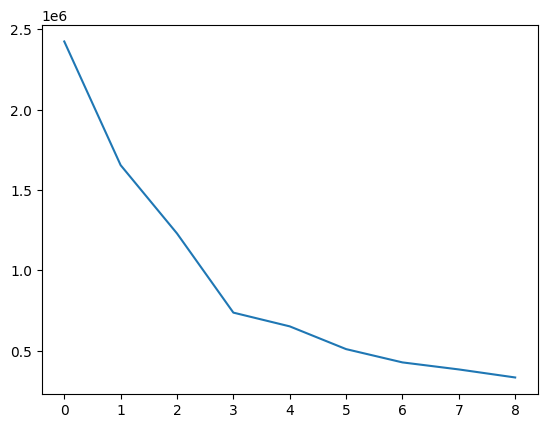

In [27]:
wcss = []
for k in range(1,10):
    kmeans = KMeans(n_clusters = k, max_iter = 50,random_state = 42 )
    kmeans.fit(rfm_trans_df_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(wcss)

### Based on Elbow Method selecting K = 3

In [28]:
kmeans = KMeans(n_clusters=3, max_iter=50,random_state = 3)
kmeans.fit(rfm_trans_df_scaled)

KMeans(max_iter=50, n_clusters=3, random_state=3)

In [29]:
rfm_trans['Cluster'] = kmeans.labels_
rfm_trans.head()

,CustomerID,Frequency,Monetary,Recency,Cluster
0,C1010011,2,5106.0,25,0
1,C1010012,1,1499.0,68,2
2,C1010014,2,1455.0,75,0
3,C1010018,1,30.0,36,1
4,C1010024,1,5000.0,64,2


<Axes: xlabel='Cluster', ylabel='Monetary'>

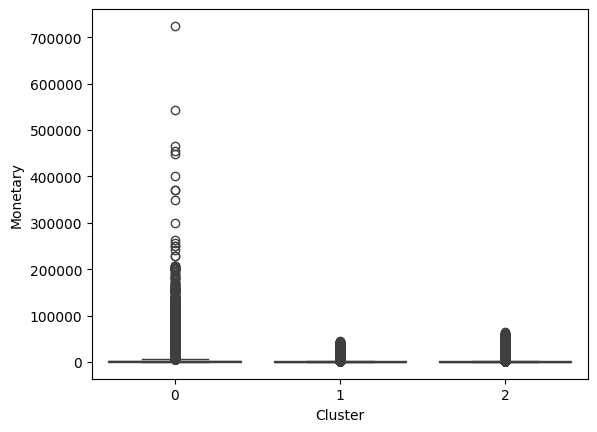

In [30]:
sns.boxplot(x='Cluster', y='Monetary', data=rfm_trans)

<Axes: xlabel='Cluster', ylabel='Frequency'>

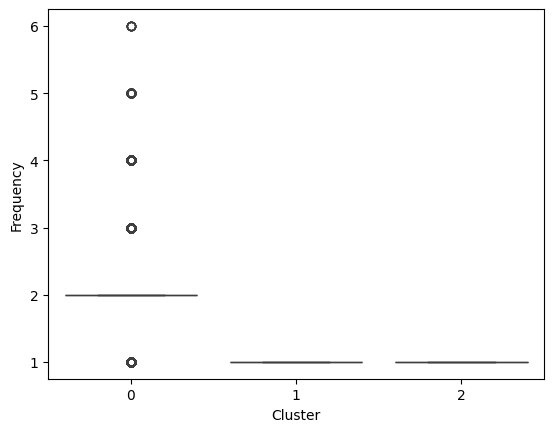

In [31]:
sns.boxplot(x='Cluster', y='Frequency', data=rfm_trans)

<Axes: xlabel='Cluster', ylabel='Recency'>

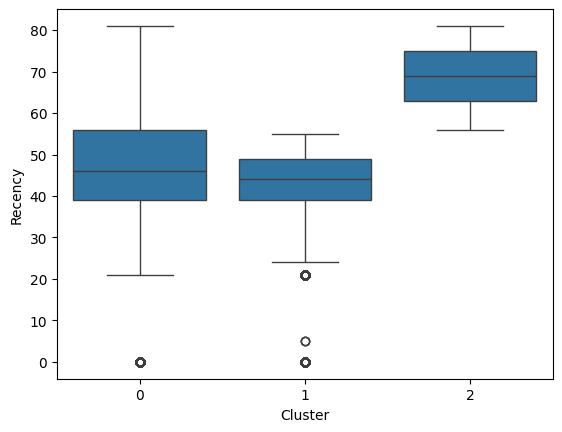

In [32]:
sns.boxplot(x='Cluster', y='Recency', data=rfm_trans)

In [33]:
file_name = 'KMeans_model.pkl'

with open(file_name, 'wb') as file:
    pickle.dump(kmeans, file)
